In [1]:
%matplotlib inline

In [2]:
import os
import pickle
import sys
from collections import Counter, defaultdict
from copy import deepcopy
from itertools import combinations, product

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw
from joblib import Parallel, delayed
from matplotlib import colors
from networkx.algorithms.community.quality import modularity as nx_modularity
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils.testing import ignore_warnings
from tqdm.notebook import tqdm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF


sys.path.append('../../pygkernels')
from pygkernels.measure import kernels
from pygkernels.scenario import d3_colors

/home/illusionww/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import datetime
print(datetime.datetime.now())

2020-09-03 10:47:00.653125


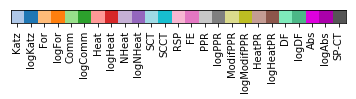

In [4]:
a = np.zeros((1, 25, 3), dtype=np.uint8)
labels = []
for idx, kernel in enumerate(kernels):
    a[0, idx] = np.array(colors.to_rgb(d3_colors[kernel.name])) * 255
    labels.append(kernel.name)
plt.imshow(a)
plt.xticks(range(25), labels, rotation='vertical')
plt.yticks([]);

In [5]:
def np2nx(A: np.ndarray, partition: np.ndarray):
    G = nx.from_numpy_matrix(A)
    nx.set_node_attributes(G, dict(enumerate(partition)), 'community')
    return G

def partition2communities(partition):
    result = defaultdict(list)
    for idx, class_ in enumerate(partition):
        result[class_].append(idx)
    return list(result.values())


def estimate_mu(graph, partition):
    n_out_edges = 0
    n_nodes = graph.size()
    for n1, n2 in graph.edges():  # links:
        if partition[n1] != partition[n2]:
            n_out_edges += 1
    return n_out_edges / n_nodes


def power_law(values, maxval=200):
    tau = powerlaw.Fit(values, verbose=False).alpha
    if tau > maxval or np.isnan(tau):
        tau = maxval
    return tau


def create_krondecker(partition):
    n = len(partition)
    kron_mask = np.tile(partition, n) == np.repeat(partition, n)

    return np.reshape(kron_mask, (n, n))

def modularity2(AIJ, partition):
    n = len(AIJ)
    m = np.sum(AIJ)  # no of edges

    k = np.sum(AIJ, axis=1)
    expectation = np.reshape(np.tile(k, n) * np.repeat(k, n), (n, n)) / m
    kron = create_krondecker(partition)

    # Q = (1 / 2m) * SUM(AIJ - (ki.kj / 2m)) ∂(ci, cj)
    return (1.0 / m) * np.sum(kron * (AIJ - expectation))


def redetect_params(data):
    A, partition = data['A'], data['y_true']
    G = np2nx(A, partition)
    
    n = G.number_of_nodes()
    average_degree = 2 * G.number_of_edges() / n
    node_degrees = [d for n, d in G.degree()]
    min_degree = np.min(node_degrees)
    max_degree = np.max(node_degrees)
    tau1 = power_law(node_degrees, 250)
    modularity = nx_modularity(G, partition2communities(partition))

    # Community-based parameters
    k = len(set(partition))
    mu = min(max(estimate_mu(G, partition), 0.), 1.)
    community_sizes = list(Counter(partition).values())
    min_community = np.min(community_sizes)
    max_community = np.max(community_sizes)
    tau2 = power_law(community_sizes, 250)
    
    return {
        'n': n,
        'k': k,
        'average_degree': average_degree,
        'min_degree': min_degree, 
        'max_degree': max_degree,
        'tau1': tau1,
        'mu': mu,
        'min_community': min_community,
        'max_community': max_community,
        'tau2': tau2,
        'modularity': modularity
    }

In [6]:
np.sum([[11, 12, 13], [21, 22, 23]], axis=0)

array([32, 34, 36])

In [7]:
root = '/media/illusionww/68949C3149F4E819/phd/pygkernels/montecarlo_lfr'
    
def perform_one(fn):
    with open(f'{root}/{fn}', 'rb') as f:
        data = pickle.load(f)
    need_to_save = False
    A = data['A']
    item = {}
    for kernel_name, kernel_results in data['results'].items():
        kernel_best_ari = -1
        for parameter, parameter_results in kernel_results.items():
            if len(parameter_results) > 0:
                if 'new_modularity2' not in parameter_results[0]:  # add new_modularity if not exist
                    for init_idx, init in enumerate(parameter_results):
                        partition = init['labels']
                        init['new_modularity2'] = modularity2(A, partition)
                    need_to_save = True
                param_best_ari = sorted(parameter_results, key=lambda x: -x['new_modularity2'])[0]['score_ari']
                kernel_best_ari = max(kernel_best_ari, param_best_ari)
        item[kernel_name] = kernel_best_ari
    
    if need_to_save:
        with open(f'{root}/{fn}', 'wb') as f:
            pickle.dump(data, f)
    
    return item, redetect_params(data)

dataset = Parallel(n_jobs=12)(delayed(perform_one)(fn) for fn in tqdm(os.listdir(root)))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [8]:
# generate additional features
for item in dataset:
    item[1]['maxari'] = np.max(list(item[0].values()))
    item[1]['average_degree/n'] = item[1]['average_degree'] / item[1]['n']

In [9]:
dataset[0]

({'Katz': 0.1429144148835836,
  'logKatz': 0.4409365359200871,
  'For': 0.011806037718625746,
  'logFor': 0.31984318212926616,
  'Comm': 0.16101858587315618,
  'logComm': 0.3654948835662535,
  'Heat': 0.008029119101342626,
  'logHeat': 0.09278927135814646,
  'NHeat': 0.3426004146382099,
  'logNHeat': 0.42626930796187673,
  'SCT': 0.6402286022746339,
  'SCCT': 0.6723689518427769,
  'RSP': 0.578839306718301,
  'FE': 0.4361064096048135,
  'PPR': 0.021378616857131837,
  'logPPR': 0.4282238544368487,
  'ModifPPR': 0.0018484419692191478,
  'logModifPPR': 0.4282238544368487,
  'HeatPR': 0.41810265887494713,
  'logHeatPR': 0.42626930796187673,
  'DF': 0.1429144148835836,
  'logDF': 0.005508380245445584,
  'Abs': 0.033755033080549994,
  'logAbs': 0.49289815801917974,
  'SP-CT': 0.5537528493741254},
 {'n': 1372,
  'k': 6,
  'average_degree': 262.3250728862974,
  'min_degree': 146,
  'max_degree': 1023,
  'tau1': 6.0327809625039075,
  'mu': 0.7097441026923398,
  'min_community': 147,
  'max_commu

# My own knn

In [10]:
def euclidean_distances(X, Y):
    X, Y = np.array(X), np.array(Y)
#     assert X.shape[1:] == Y.shape[1:], f'{X.shape}, {Y.shape}'
    result = np.sqrt(np.sum(np.power(X[:, None] - Y[None, :], 2), axis=2))
#     assert result.shape[0] == X.shape[0] and result.shape[1] == Y.shape[0], result.shape
    return result

In [11]:
class MyGaussianFilter:
    def __init__(self, sigma=0.05):
        self.sigma = sigma
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        gaussian_weights = np.exp(-np.power(pair_distance, 2) / (2 * self.sigma**2))
        for test_idx in range(len(X_test)):
            chosen_indices = []
            for train_idx in range(len(self.X)):
                if pair_distance[test_idx, train_idx] < 3 * self.sigma:
                    chosen_indices.append(train_idx)
            if len(chosen_indices) < 3:
                chosen_indices = []
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            sum_weights = np.sum([gaussian_weights[test_idx, chosen_idx] for chosen_idx in chosen_indices])
            for chosen_idx in chosen_indices:
                weighted_results += gaussian_weights[test_idx, chosen_idx] * self.y[chosen_idx] / sum_weights
            output.append(weighted_results)
        return np.array(output)

In [12]:
def prepare_field_filter(dataset, feature_names, distance=0.05):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset])
    
    knn = MyGaussianFilter(sigma=distance)
    knn.fit(X, y)
    
    arr = np.zeros([resolution] * len(feature_names) + [y.shape[1]], dtype=np.float32)
    plot = np.zeros([resolution] * len(feature_names) + [3], dtype=np.uint8)
    params_spaces = [np.linspace(limits[fname][0], limits[fname][1], resolution) for fname in feature_names]
    print(params_spaces)
    for point in tqdm(product(*[range(resolution) for _ in range(len(feature_names))]), total=resolution ** len(feature_names)):
        params = [params_spaces[i][point[i]] for i in range(len(feature_names))]
        pixels_kernels_results = knn.predict([params])[0]
        arr[point] = pixels_kernels_results
        
        if ~np.all(pixels_kernels_results == 0):
            pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
            plot[point] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
        else:
            plot[point] = np.array([1, 1, 1]) * 255
    
    return X, y, arr, plot

In [13]:
def doplot(ax, X, y, plot, feature_names, scatter=True):
    ax.imshow(plot)
        
    n_ticks = 10 if feature_names[1] not in ['tau1', 'tau2'] else 2 
    ax.set_xticks(np.linspace(0, resolution-1, n_ticks))
    ax.set_xticklabels([f'{x:.2f}' for x in np.linspace(real_limits[feature_names[1]][0], real_limits[feature_names[1]][1], n_ticks)], rotation='vertical');
    ax.set_xlabel(feature_names[1])
    ax.set_xlim(0, resolution-1)
    
    n_ticks = 10 if feature_names[0] not in ['tau1', 'tau2'] else 2 
    ax.set_yticks(np.linspace(0, resolution-1, n_ticks))
    ax.set_yticklabels([f'{x:.2f}' for x in np.linspace(real_limits[feature_names[0]][0], real_limits[feature_names[0]][1], n_ticks)]);
    ax.set_ylabel(feature_names[0])
    ax.set_ylim(0, resolution-1)

    if scatter:
        ax.scatter([point2plot(x, feature_names[1]) for x in X[:, 1]], [point2plot(x, feature_names[0]) for x in X[:, 0]], s=1, c='black')

# Plot knn of two features

In [14]:
all_feature_names = [
    'n',
    'tau1',
    'tau2',
    'mu',
    'average_degree',
    'maxari',
    'modularity',
    'average_degree/n',
]

fnc = {
    'n': lambda x: x/1500,
    'tau1': lambda x: 1 - (1 / x**0.5),
    'tau2': lambda x: 1 - (1 / x**0.5),
    'mu': lambda x: x,
    'average_degree': lambda x: x/940,
    'maxari': lambda x: x,
    'modularity': lambda x: (x + 0.5) * 0.69,
    'average_degree/n': lambda x: x * 1.25,
}

kernels_order = [x.name for x in kernels]

In [15]:
real_limits = {}
limits = {}
for fname in all_feature_names:
    min_max = np.min([info[fname] for _, info in dataset]), np.max([info[fname] for _, info in dataset])
    real_limits[fname] = min_max
    limits[fname] = fnc[fname](min_max[0]), fnc[fname](min_max[1])
    print(f'{fname}: {real_limits[fname][0]:.2f}, {real_limits[fname][1]:.2f} | {limits[fname][0]:.2f}, {limits[fname][1]:.2f}')
    
def point2plot(x, feature_name):
    vmin, vmax = limits[feature_name]
    return (x - vmin) / (vmax - vmin) * (resolution - 1)

n: 10.00, 1499.00 | 0.01, 1.00
tau1: 1.96, 235.90 | 0.28, 0.93
tau2: 1.51, 250.00 | 0.19, 0.94
mu: 0.00, 1.00 | 0.00, 1.00
average_degree: 1.17, 940.53 | 0.00, 1.00
maxari: 0.00, 1.00 | 0.00, 1.00
modularity: -0.49, 0.95 | 0.01, 1.00
average_degree/n: 0.00, 0.80 | 0.00, 1.00


In [16]:
distance = 0.05
resolution = 30

feature_names = ['tau1', 'mu', 'average_degree/n', 'maxari']
X, y, arr, plot = prepare_field_filter(dataset, feature_names, distance=distance)

[array([0.28498893, 0.30739937, 0.3298098 , 0.35222023, 0.37463066,
       0.39704109, 0.41945152, 0.44186195, 0.46427239, 0.48668282,
       0.50909325, 0.53150368, 0.55391411, 0.57632454, 0.59873498,
       0.62114541, 0.64355584, 0.66596627, 0.6883767 , 0.71078713,
       0.73319756, 0.755608  , 0.77801843, 0.80042886, 0.82283929,
       0.84524972, 0.86766015, 0.89007058, 0.91248102, 0.93489145]), array([8.10471289e-05, 3.45610110e-02, 6.90409749e-02, 1.03520939e-01,
       1.38000903e-01, 1.72480867e-01, 2.06960830e-01, 2.41440794e-01,
       2.75920758e-01, 3.10400722e-01, 3.44880686e-01, 3.79360650e-01,
       4.13840614e-01, 4.48320578e-01, 4.82800542e-01, 5.17280506e-01,
       5.51760469e-01, 5.86240433e-01, 6.20720397e-01, 6.55200361e-01,
       6.89680325e-01, 7.24160289e-01, 7.58640253e-01, 7.93120217e-01,
       8.27600181e-01, 8.62080144e-01, 8.96560108e-01, 9.31040072e-01,
       9.65520036e-01, 1.00000000e+00]), array([0.00444858, 0.03889163, 0.07333468, 0.10777773, 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an 

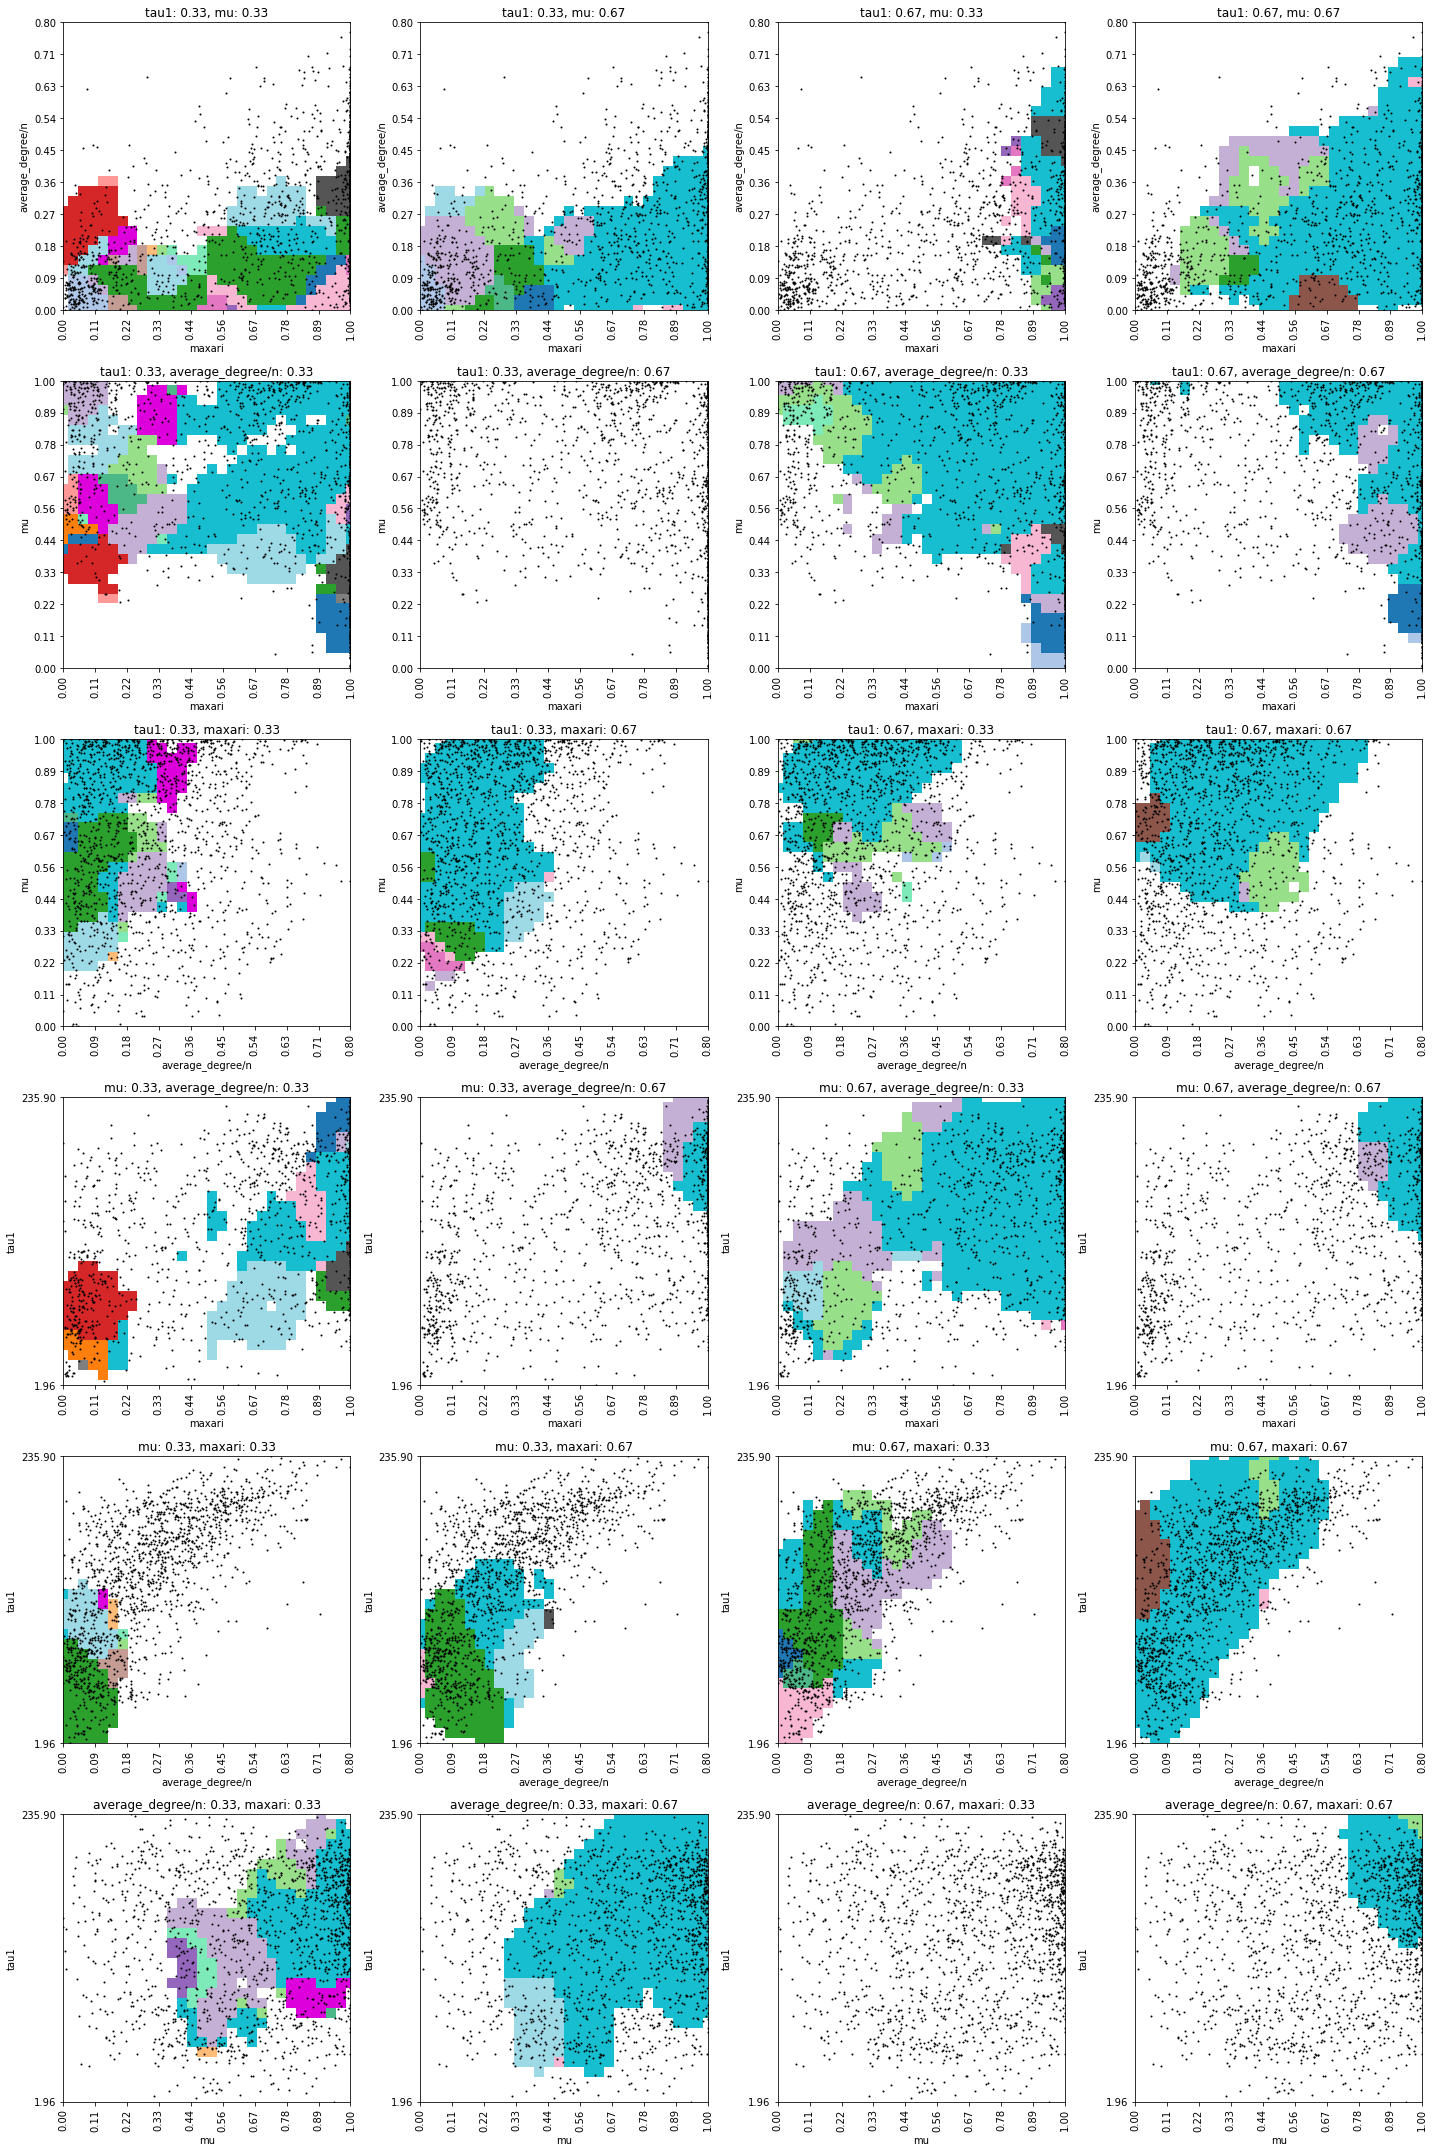

In [17]:
fig, ax = plt.subplots(6, 4, figsize=(20, 30))

a1, a2, atotal = int(resolution / 3), int(resolution * 2 / 3), resolution
for idx, (b1, b2, w1, w2) in enumerate([
            [0, 1, 2, 3],
            [0, 2, 1, 3],
            [0, 3, 1, 2],
            [1, 2, 0, 3],
            [1, 3, 0, 2],
            [2, 3, 0, 1]
        ]):
    slice_ = [slice(None)] * 4; slice_[b1] = a1; slice_[b2] = a1
    doplot(ax[idx][0], X[:, (w1, w2)], y, plot[slice_], (feature_names[w1], feature_names[w2]))
    ax[idx][0].set_title(f'{feature_names[b1]}: {a1/atotal:.2f}, {feature_names[b2]}: {a1/atotal:.2f}')
    
    slice_ = [slice(None)] * 4; slice_[b1] = a1; slice_[b2] = a2
    doplot(ax[idx][1], X[:, (w1, w2)], y, plot[slice_], (feature_names[w1], feature_names[w2]))
    ax[idx][1].set_title(f'{feature_names[b1]}: {a1/atotal:.2f}, {feature_names[b2]}: {a2/atotal:.2f}')
    
    slice_ = [slice(None)] * 4; slice_[b1] = a2; slice_[b2] = a1
    doplot(ax[idx][2], X[:, (w1, w2)], y, plot[slice_], (feature_names[w1], feature_names[w2]))
    ax[idx][2].set_title(f'{feature_names[b1]}: {a2/atotal:.2f}, {feature_names[b2]}: {a1/atotal:.2f}')
    
    slice_ = [slice(None)] * 4; slice_[b1] = a2; slice_[b2] = a2
    doplot(ax[idx][3], X[:, (w1, w2)], y, plot[slice_], (feature_names[w1], feature_names[w2]))
    ax[idx][3].set_title(f'{feature_names[b1]}: {a2/atotal:.2f}, {feature_names[b2]}: {a2/atotal:.2f}')

plt.tight_layout()

# Measure statistics

In [18]:
measure_statistics = defaultdict(lambda: 0)
for point in product(*([range(resolution)] * len(feature_names))):
    measure_results = arr[point]
    if not np.all(measure_results == 0):  # if not empty point
        best_measure_name = kernels_order[np.argmax(measure_results)]
#         print(measure_results)
        measure_statistics[best_measure_name] += 1

In [19]:
Counter(measure_statistics).most_common()

[('SCCT', 118731),
 ('NHeat', 26826),
 ('logComm', 14969),
 ('Comm', 12825),
 ('logKatz', 10802),
 ('SCT', 7852),
 ('RSP', 7012),
 ('Katz', 5494),
 ('SP-CT', 3992),
 ('Heat', 2507),
 ('Abs', 1941),
 ('DF', 1804),
 ('logDF', 1488),
 ('logHeat', 1264),
 ('FE', 1091),
 ('logNHeat', 960),
 ('logHeatPR', 933),
 ('logPPR', 750),
 ('logFor', 714),
 ('logModifPPR', 453),
 ('HeatPR', 405),
 ('For', 229),
 ('PPR', 152),
 ('logAbs', 102),
 ('ModifPPR', 25)]

# GMM for every measure

In [20]:
res = {}

for measure_name in [
            'SCCT',
            'NHeat',
            'Comm',
            'logComm',
            'SCT',
            'logKatz',
            'RSP',
            'Heat'
        ]:
    measure_idx = kernels_order.index(measure_name)
    Xm, ym = [], []
    for point in product(*([range(resolution)] * len(feature_names))):
        if not np.all(arr[point] == 0):  # if not empty point
            Xm.append(np.array(point) / resolution)
            ym.append(np.argmax(arr[point]) == measure_idx)
    Xm, ym = np.array(Xm), np.array(ym)
        
    gmm = GaussianMixture(n_components=1)
    gmm.fit(Xm[ym == 1])
    
    gmm_all = GaussianMixture(n_components=1)
    gmm_all.fit(Xm)
    
    means = (gmm.means_[0] - gmm_all.means_[0])
#     means = (gmm.means_[0] - 0.5) / resolution
#     means = np.mean(Xm[ym == 1], axis=0) - np.mean(Xm, axis=0)
    covs = gmm.covariances_[0].diagonal() / gmm_all.covariances_[0].diagonal()
    
    print(measure_name)
    print(feature_names)
    print(means)
    print(covs)
    
    res[measure_name] = {
        'means_c0': {k: v for k, v in zip(feature_names, means)},
        'cov_diag_c0': {k: v for k, v in zip(feature_names, covs)},
    }
    
#     break

SCCT
['tau1', 'mu', 'average_degree/n', 'maxari']
[0.03347192 0.10315502 0.02555464 0.07487999]
[0.92811961 0.55992814 0.98994747 0.61568171]
NHeat
['tau1', 'mu', 'average_degree/n', 'maxari']
[ 0.04700504  0.05577862  0.05068287 -0.21588062]
[0.90375482 0.6368497  1.35074127 1.11010143]
Comm
['tau1', 'mu', 'average_degree/n', 'maxari']
[ 0.11980142  0.08108265  0.00419751 -0.24113301]
[0.71019227 0.51838373 0.58176362 0.5641511 ]
logComm
['tau1', 'mu', 'average_degree/n', 'maxari']
[-0.19958368 -0.19516479 -0.17624322 -0.12172703]
[0.53810752 0.26543393 0.13801744 0.74835343]
SCT
['tau1', 'mu', 'average_degree/n', 'maxari']
[-0.17103253 -0.27434281 -0.09475304  0.05615278]
[0.50364192 0.77865019 0.38074798 1.12572419]
logKatz
['tau1', 'mu', 'average_degree/n', 'maxari']
[ 0.06544765 -0.3763831   0.05903539  0.24116381]
[1.11565129 0.29743249 1.10770194 0.69043354]
RSP
['tau1', 'mu', 'average_degree/n', 'maxari']
[-0.23232184 -0.14078211 -0.12017432  0.12293293]
[0.68285144 0.30179627 

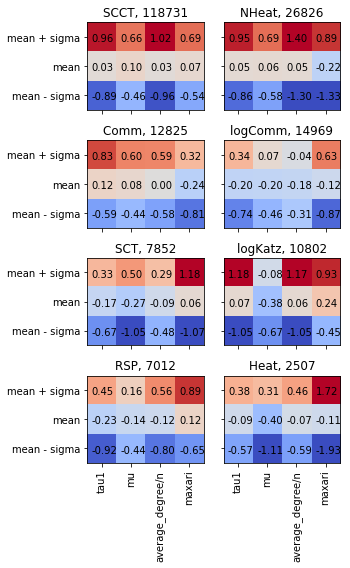

In [21]:
fig, ax = plt.subplots(4, 2, figsize=(5, 8), sharex=True, sharey=True)

for measure_idx, measure_name in enumerate([
            'SCCT',
            'NHeat',
            'Comm',
            'logComm',
            'SCT',
            'logKatz',
            'RSP',
            'Heat'
        ]):
    image_means = np.zeros((3, len(feature_names)))
    image_cov_diag = np.zeros((3, len(feature_names)))
    for feature_idx, feature_name in enumerate(feature_names):
        image_means[0, feature_idx] = res[measure_name]['means_c0'][feature_name] + res[measure_name]['cov_diag_c0'][feature_name]
        image_means[1, feature_idx] = res[measure_name]['means_c0'][feature_name]
        image_means[2, feature_idx] = res[measure_name]['means_c0'][feature_name] - res[measure_name]['cov_diag_c0'][feature_name]
    
    axi = ax[measure_idx // 2][measure_idx % 2] 
    axi.imshow(image_means, vmin=-1, vmax=1, cmap=plt.get_cmap('coolwarm'))
    axi.set_xticks(range(len(feature_names)))
    axi.set_xticklabels(feature_names, rotation=90)
    axi.set_yticks(range(3))
    axi.set_yticklabels(['mean + sigma', 'mean', 'mean - sigma'])
    axi.set_title(f'{measure_name}, {measure_statistics[measure_name]}')
    
    for feature_idx, feature_name in enumerate(feature_names):
        axi.text(feature_idx-0.35, 0.15, f'{image_means[0][feature_idx]:.2f}')
        axi.text(feature_idx-0.35, 1.15, f'{image_means[1][feature_idx]:.2f}')
        axi.text(feature_idx-0.35, 2.15, f'{image_means[2][feature_idx]:.2f}')
    
plt.tight_layout()

# Min features

In [40]:
class RFE:
    def __init__(self, estimator, names, max_features=5, n_jobs=None):
        self.estimator = estimator
        self.names = names
        self.max_features = max_features
        self.n_jobs = n_jobs
        self.results = {}

    @ignore_warnings(category=ConvergenceWarning)
    def score_one(self, x, y, weights, set_feat_names):
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)

        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        y_pred = estimator.predict_proba(x[:, support])[:, 1]
        f1 = f1_score(y, y_pred > 0.5)
        return set_feat_names, f1, estimator

    def fit(self, x, y, weights):
        # for all features first:
        _, f1_all, estimator_all = self.score_one(x, y, weights, self.names)
        print(f'all features, f1={f1_all:.3f}')

        for n_features in range(1, self.max_features + 1):
            results = Parallel(n_jobs=self.n_jobs)(
                delayed(self.score_one)(x, y, weights, set_feat_names)
                for set_feat_names in list(combinations(self.names, n_features)))
            best_n_feat, best_f1, best_estimator = None, 0, None
            for set_feat_names, f1, estimator in results:
                if f1 > best_f1:
                    best_n_feat, best_f1, best_estimator = set_feat_names, f1, estimator
            print(f'{n_features} features, f1={best_f1:.3f}, set={best_n_feat}')
            if hasattr(best_estimator, 'best_params_'):
                print(best_estimator.best_params_)
            self.results[n_features] = {
                'f1': best_f1,
                'set': best_n_feat
            }

        return self

    def draw1d(self, x, y, weights):
        set_feat_names = self.results[1]['set']
        print(set_feat_names)
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)
        print(support)
        support_idx = [x for x in range(support.shape[0]) if support[x]]
        print(support_idx)
        
        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        y_pred = estimator.predict_proba(x[:, support])[:, 1]
        f1 = f1_score(y, y_pred > 0.5)
        
        print(f'f1: {f1:.3f}')

        fig, ax = plt.subplots(1, 2, figsize=(16, 3))
        ax[0].scatter(x[:, support_idx[0]], [np.random.rand() for _ in range(x.shape[0])], c=ty_bool)
        ax[0].set_title('gt')
        ax[1].scatter(x[:, support_idx[0]], [np.random.rand() for _ in range(x.shape[0])], c=y_pred)
        ax[1].set_title('preds')

        ax[0].set_xlabel(set_feat_names[0])
        ax[1].set_xlabel(set_feat_names[0])

        plt.tight_layout()
    
    def draw2d(self, x, y, weights):
        set_feat_names = self.results[2]['set']
        print(set_feat_names)
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)
        print(support)
        support_idx = [x for x in range(support.shape[0]) if support[x]]
        print(support_idx)
        
        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        y_pred = estimator.predict_proba(x[:, support])[:, 1]
        f1 = f1_score(y, y_pred > 0.5)
        
        print(f'f1: {f1:.3f}')

        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
        ax[0].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=ty_bool)
        ax[0].set_title('gt')
        ax[1].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=y_pred)
        ax[1].set_title('preds')

        ax[0].set_xlabel(set_feat_names[0])
        ax[1].set_xlabel(set_feat_names[0])
        ax[0].set_ylabel(set_feat_names[1])
        ax[1].set_ylabel(set_feat_names[1])

        plt.tight_layout()
        
    def draw3d(self, x, y, weights):
        set_feat_names = self.results[3]['set']
        print(set_feat_names)
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)
        print(support)
        support_idx = [x for x in range(support.shape[0]) if support[x]]
        print(support_idx)
        
        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        y_pred = estimator.predict_proba(x[:, support])[:, 1]
        f1 = f1_score(y, y_pred > 0.5)
        
        print(f'f1: {f1:.3f}')

        fig, ax = plt.subplots(2, 2, figsize=(16, 16))
        ax[0][0].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=ty_bool)
        ax[0][0].set_title('gt')
        ax[0][1].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=y_pred)
        ax[0][1].set_title('preds')

        ax[0][0].set_xlabel(set_feat_names[0])
        ax[0][1].set_xlabel(set_feat_names[0])
        ax[0][0].set_ylabel(set_feat_names[1])
        ax[0][1].set_ylabel(set_feat_names[1])
        
        ax[1][0].scatter(x[:, support_idx[1]], x[:, support_idx[2]], c=ty_bool)
        ax[1][0].set_title('gt')
        ax[1][1].scatter(x[:, support_idx[1]], x[:, support_idx[2]], c=y_pred)
        ax[1][1].set_title('preds')

        ax[1][0].set_xlabel(set_feat_names[1])
        ax[1][1].set_xlabel(set_feat_names[1])
        ax[1][0].set_ylabel(set_feat_names[2])
        ax[1][1].set_ylabel(set_feat_names[2])

        plt.tight_layout()
        
    def draw4d(self, x, y, weights):
        set_feat_names = self.results[4]['set']
        print(set_feat_names)
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)
        print(support)
        support_idx = [x for x in range(support.shape[0]) if support[x]]
        print(support_idx)
        
        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        y_pred = estimator.predict_proba(x[:, support])[:, 1]
        f1 = f1_score(y, y_pred > 0.5)
        
        print(f'f1: {f1:.3f}')

        fig, ax = plt.subplots(3, 2, figsize=(16, 24))
        ax[0][0].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=ty_bool)
        ax[0][0].set_title('gt')
        ax[0][1].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=y_pred)
        ax[0][1].set_title('preds')

        ax[0][0].set_xlabel(set_feat_names[0])
        ax[0][1].set_xlabel(set_feat_names[0])
        ax[0][0].set_ylabel(set_feat_names[1])
        ax[0][1].set_ylabel(set_feat_names[1])
        
        ax[1][0].scatter(x[:, support_idx[1]], x[:, support_idx[2]], c=ty_bool)
        ax[1][0].set_title('gt')
        ax[1][1].scatter(x[:, support_idx[1]], x[:, support_idx[2]], c=y_pred)
        ax[1][1].set_title('preds')

        ax[1][0].set_xlabel(set_feat_names[1])
        ax[1][1].set_xlabel(set_feat_names[1])
        ax[1][0].set_ylabel(set_feat_names[2])
        ax[1][1].set_ylabel(set_feat_names[2])

        ax[2][0].scatter(x[:, support_idx[2]], x[:, support_idx[3]], c=ty_bool)
        ax[2][0].set_title('gt')
        ax[2][1].scatter(x[:, support_idx[2]], x[:, support_idx[3]], c=y_pred)
        ax[2][1].set_title('preds')

        ax[2][0].set_xlabel(set_feat_names[2])
        ax[2][1].set_xlabel(set_feat_names[2])
        ax[2][0].set_ylabel(set_feat_names[3])
        ax[2][1].set_ylabel(set_feat_names[3])

        plt.tight_layout()

In [23]:
feature_names = ['tau1', 'tau2', 'mu', 'average_degree/n', 'maxari', 'modularity']
tx = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
ty = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset])
tx.shape, ty.shape

((1526, 7), (1526, 25))

In [24]:
tx = tx[np.max(ty, axis=1) < 0.9999]
ty = ty[np.max(ty, axis=1) < 0.9999]
tx.shape, ty.shape

((1049, 7), (1049, 25))

In [25]:
tywo11 = ty.copy()
tywo11[:, 11] = 0

In [79]:
ddt = dict()
for measure_idx in range(25):
    ari_measure, ari_other = ty[:, measure_idx], np.max(np.concatenate((ty[:, :measure_idx], ty[:, measure_idx+1:]), axis=1), axis=1)
    ty_bool = ari_measure >= ari_other
    ddt[f'{kernels_order[measure_idx]}, {measure_idx}'] = np.sum(ty_bool)
Counter(ddt).most_common()

[('SCCT, 11', 487),
 ('NHeat, 8', 177),
 ('Comm, 4', 83),
 ('logComm, 5', 71),
 ('RSP, 12', 54),
 ('SCT, 10', 48),
 ('SP-CT, 24', 44),
 ('Katz, 0', 34),
 ('logKatz, 1', 34),
 ('DF, 20', 33),
 ('logDF, 21', 26),
 ('logHeatPR, 19', 25),
 ('logNHeat, 9', 23),
 ('logPPR, 15', 22),
 ('logModifPPR, 17', 22),
 ('FE, 13', 19),
 ('Abs, 22', 17),
 ('Heat, 6', 14),
 ('logHeat, 7', 12),
 ('logFor, 3', 10),
 ('HeatPR, 18', 10),
 ('logAbs, 23', 10),
 ('For, 2', 5),
 ('PPR, 14', 5),
 ('ModifPPR, 16', 3)]

In [80]:
ddt = dict()
for measure_idx in range(25):
    ari_measure, ari_other = tywo11[:, measure_idx], np.max(np.concatenate((tywo11[:, :measure_idx], tywo11[:, measure_idx+1:]), axis=1), axis=1)
    ty_bool = ari_measure >= ari_other
    ddt[f'{kernels_order[measure_idx]}, {measure_idx}'] = np.sum(ty_bool)
Counter(ddt).most_common()

[('NHeat, 8', 337),
 ('Comm, 4', 149),
 ('RSP, 12', 100),
 ('SCT, 10', 96),
 ('logComm, 5', 91),
 ('SP-CT, 24', 90),
 ('Katz, 0', 81),
 ('DF, 20', 75),
 ('logKatz, 1', 40),
 ('logHeatPR, 19', 37),
 ('Abs, 22', 36),
 ('logNHeat, 9', 35),
 ('logPPR, 15', 34),
 ('logModifPPR, 17', 30),
 ('logDF, 21', 30),
 ('FE, 13', 29),
 ('Heat, 6', 19),
 ('logHeat, 7', 16),
 ('logAbs, 23', 14),
 ('logFor, 3', 12),
 ('HeatPR, 18', 10),
 ('For, 2', 6),
 ('PPR, 14', 5),
 ('ModifPPR, 16', 3),
 ('SCCT, 11', 1)]

# SCCT

In [81]:
measure_idx = 11
ari_measure, ari_other = ty[:, measure_idx], np.max(np.concatenate((ty[:, :measure_idx], ty[:, measure_idx+1:]), axis=1), axis=1)
win_weights = 1 / np.sum(ty == np.max(ty, axis=1, keepdims=True), axis=1)**3
lose_weights = np.abs(ari_measure - ari_other) * 5
weights = [ww if ari_m >= ari_o else lw for ari_m, ari_o, ww, lw in zip(ari_measure, ari_other, win_weights, lose_weights)]

ty_bool = ari_measure >= ari_other
print(f'{kernels_order[measure_idx]}', np.sum(ty_bool))

rfe = RFE(SVC(probability=True), feature_names, max_features=7)
rfe.fit(tx, ty_bool, weights)

SCCT 487
all features, f1=0.807
1 features, f1=0.731, set=('maxari',)
2 features, f1=0.768, set=('mu', 'maxari')
3 features, f1=0.784, set=('n', 'mu', 'maxari')
4 features, f1=0.792, set=('n', 'tau2', 'mu', 'maxari')
5 features, f1=0.803, set=('n', 'tau1', 'mu', 'average_degree/n', 'maxari')
6 features, f1=0.807, set=('n', 'tau1', 'mu', 'average_degree/n', 'maxari', 'modularity')
7 features, f1=0.808, set=('n', 'tau1', 'tau2', 'mu', 'average_degree/n', 'maxari', 'modularity')


('mu', 'maxari')
[False False False  True False  True False]
[3, 5]
f1: 0.770


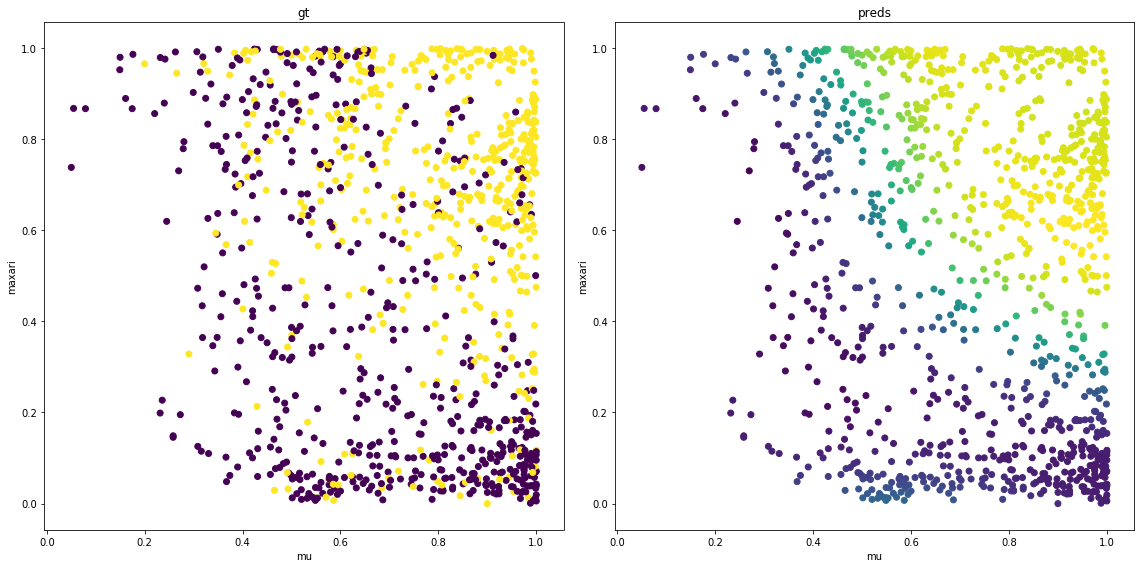

In [82]:
rfe.draw2d(tx, ty_bool, weights)

# NHeat

In [83]:
measure_idx = 8
# ari_measure, ari_other = ty[:, measure_idx], np.max(np.concatenate((ty[:, :measure_idx], ty[:, measure_idx+1:]), axis=1), axis=1)
ari_measure, ari_other = tywo11[:, measure_idx], np.max(np.concatenate((tywo11[:, :measure_idx], tywo11[:, measure_idx+1:]), axis=1), axis=1)
win_weights = 1 / np.sum(ty == np.max(ty, axis=1, keepdims=True), axis=1)**3
lose_weights = np.abs(ari_measure - ari_other) * 5
weights = [ww if ari_m >= ari_o else lw for ari_m, ari_o, ww, lw in zip(ari_measure, ari_other, win_weights, lose_weights)]

ty_bool = ari_measure >= ari_other
print(f'{kernels_order[measure_idx]}', np.sum(ty_bool))

rfe = RFE(SVC(probability=True), feature_names, max_features=7)
rfe.fit(tx, ty_bool, weights)

NHeat 337
all features, f1=0.493
1 features, f1=0.416, set=('mu',)
2 features, f1=0.475, set=('tau1', 'modularity')
3 features, f1=0.477, set=('tau1', 'average_degree/n', 'modularity')
4 features, f1=0.482, set=('tau1', 'mu', 'average_degree/n', 'maxari')
5 features, f1=0.520, set=('tau1', 'mu', 'average_degree/n', 'maxari', 'modularity')
6 features, f1=0.497, set=('tau1', 'tau2', 'mu', 'average_degree/n', 'maxari', 'modularity')
7 features, f1=0.492, set=('n', 'tau1', 'tau2', 'mu', 'average_degree/n', 'maxari', 'modularity')


('tau1', 'average_degree/n', 'modularity')
[False  True False False  True False  True]
[1, 4, 6]
f1: 0.468


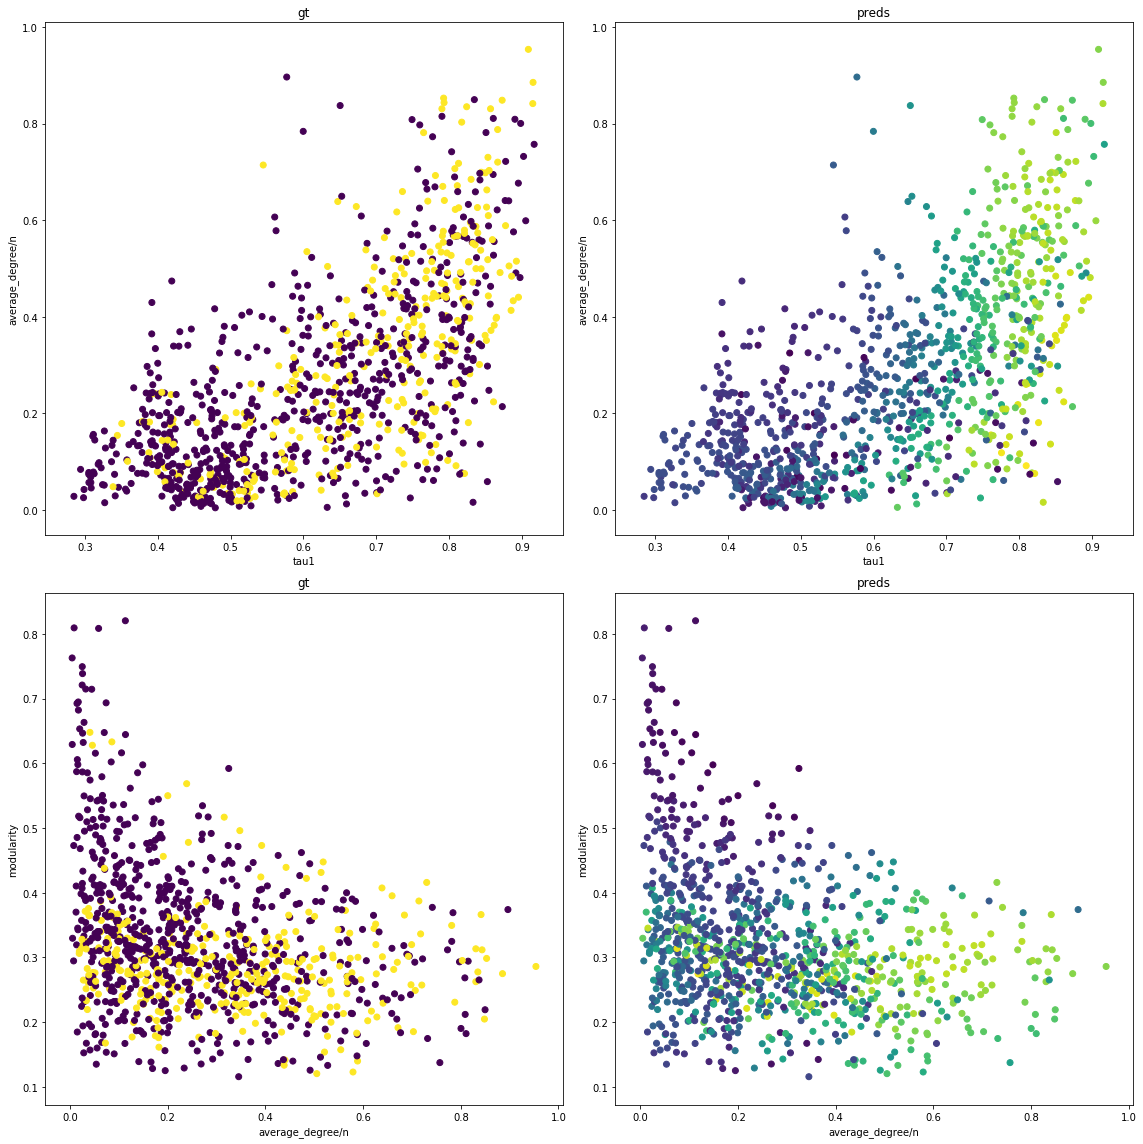

In [84]:
rfe.draw3d(tx, ty_bool, weights)

# Comm

In [85]:
measure_idx = 4
# ari_measure, ari_other = ty[:, measure_idx], np.max(np.concatenate((ty[:, :measure_idx], ty[:, measure_idx+1:]), axis=1), axis=1)
ari_measure, ari_other = tywo11[:, measure_idx], np.max(np.concatenate((tywo11[:, :measure_idx], tywo11[:, measure_idx+1:]), axis=1), axis=1)
win_weights = 1 / np.sum(ty == np.max(ty, axis=1, keepdims=True), axis=1)**3
lose_weights = np.abs(ari_measure - ari_other) * 5
weights = [ww if ari_m >= ari_o else lw for ari_m, ari_o, ww, lw in zip(ari_measure, ari_other, win_weights, lose_weights)]

ty_bool = ari_measure >= ari_other
print(f'{kernels_order[measure_idx]}', np.sum(ty_bool))

rfe = RFE(SVC(probability=True), feature_names, max_features=7)
rfe.fit(tx, ty_bool, weights)

Comm 149
all features, f1=0.000
1 features, f1=0.000, set=None
2 features, f1=0.026, set=('tau1', 'average_degree/n')
3 features, f1=0.108, set=('tau1', 'maxari', 'modularity')
4 features, f1=0.110, set=('tau1', 'tau2', 'maxari', 'modularity')
5 features, f1=0.089, set=('tau1', 'tau2', 'average_degree/n', 'maxari', 'modularity')
6 features, f1=0.075, set=('n', 'tau1', 'tau2', 'mu', 'average_degree/n', 'modularity')
7 features, f1=0.000, set=None


('tau1', 'average_degree/n')
[False  True False False  True False False]
[1, 4]
f1: 0.013


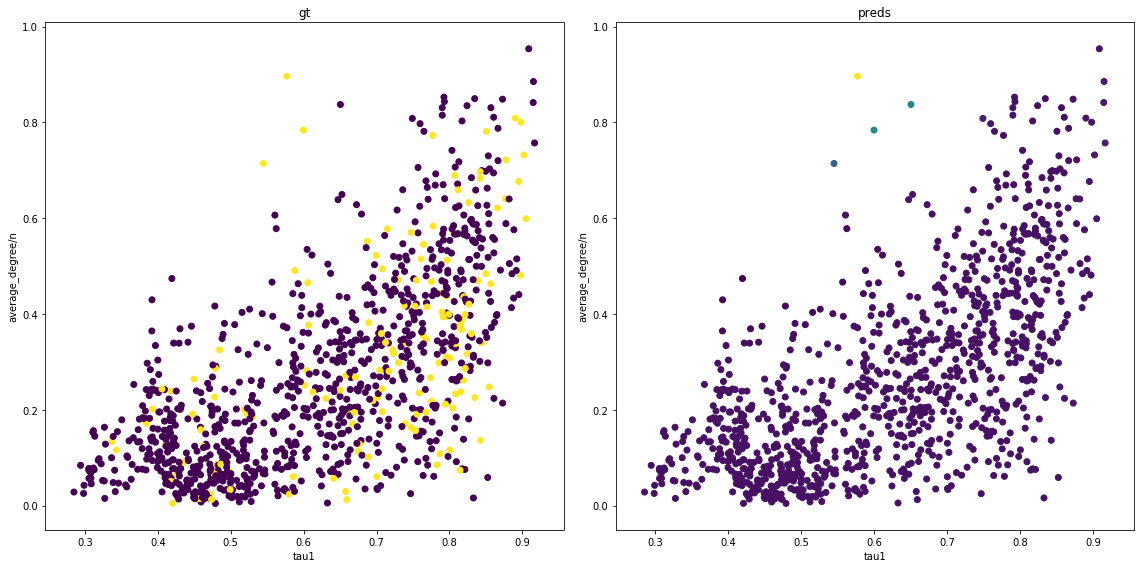

In [86]:
rfe.draw2d(tx, ty_bool, weights)

# logComm

In [94]:
measure_idx = 5
# ari_measure, ari_other = ty[:, measure_idx], np.max(np.concatenate((ty[:, :measure_idx], ty[:, measure_idx+1:]), axis=1), axis=1)
ari_measure, ari_other = tywo11[:, measure_idx], np.max(np.concatenate((tywo11[:, :measure_idx], tywo11[:, measure_idx+1:]), axis=1), axis=1)
win_weights = 1 / np.sum(ty == np.max(ty, axis=1, keepdims=True), axis=1)**3
lose_weights = np.abs(ari_measure - ari_other) * 5
weights = [ww if ari_m >= ari_o else lw for ari_m, ari_o, ww, lw in zip(ari_measure, ari_other, win_weights, lose_weights)]

ty_bool = ari_measure >= ari_other
print(f'{kernels_order[measure_idx]}', np.sum(ty_bool))

rfe = RFE(SVC(probability=True), feature_names, max_features=7)
rfe.fit(tx, ty_bool, weights)

logComm 91
all features, f1=0.222
1 features, f1=0.000, set=None
2 features, f1=0.153, set=('average_degree/n', 'modularity')
3 features, f1=0.244, set=('n', 'tau1', 'modularity')
4 features, f1=0.246, set=('tau2', 'average_degree/n', 'maxari', 'modularity')
5 features, f1=0.200, set=('n', 'tau1', 'average_degree/n', 'maxari', 'modularity')
6 features, f1=0.220, set=('n', 'tau1', 'mu', 'average_degree/n', 'maxari', 'modularity')
7 features, f1=0.200, set=('n', 'tau1', 'tau2', 'mu', 'average_degree/n', 'maxari', 'modularity')


('n', 'tau1', 'modularity')
[ True  True False False False False  True]
[0, 1, 6]
f1: 0.000


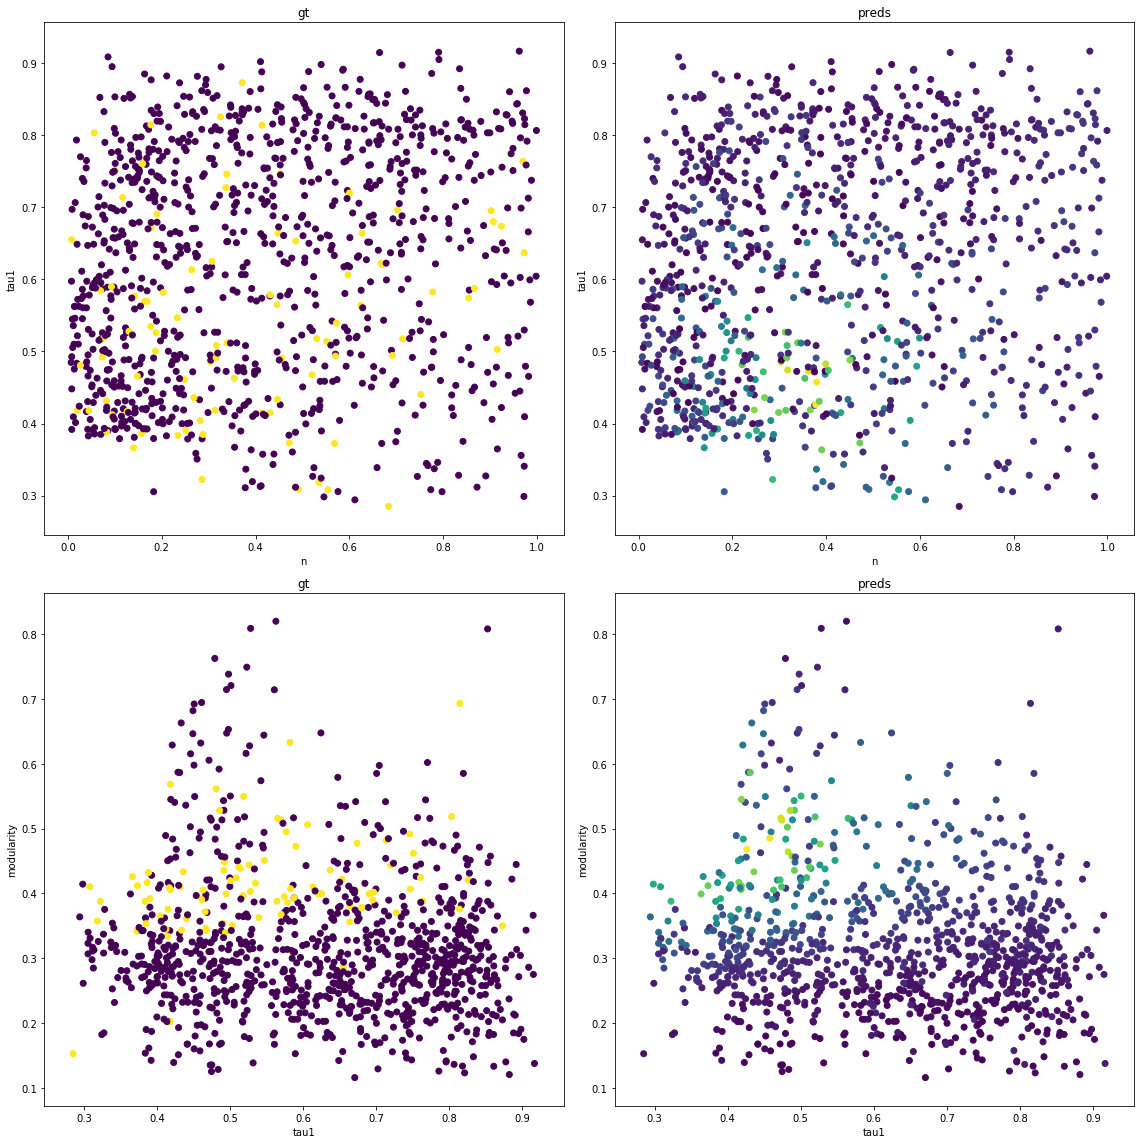

In [95]:
rfe.draw3d(tx, ty_bool, weights)

# SCT

In [96]:
measure_idx = 10
# ari_measure, ari_other = ty[:, measure_idx], np.max(np.concatenate((ty[:, :measure_idx], ty[:, measure_idx+1:]), axis=1), axis=1)
ari_measure, ari_other = tywo11[:, measure_idx], np.max(np.concatenate((tywo11[:, :measure_idx], tywo11[:, measure_idx+1:]), axis=1), axis=1)
win_weights = 1 / np.sum(ty == np.max(ty, axis=1, keepdims=True), axis=1)**3
lose_weights = np.abs(ari_measure - ari_other) * 5
weights = [ww if ari_m >= ari_o else lw for ari_m, ari_o, ww, lw in zip(ari_measure, ari_other, win_weights, lose_weights)]

ty_bool = ari_measure >= ari_other
print(f'{kernels_order[measure_idx]}', np.sum(ty_bool))

rfe = RFE(SVC(probability=True), feature_names, max_features=7)
rfe.fit(tx, ty_bool, weights)

SCT 96
all features, f1=0.080
1 features, f1=0.000, set=None
2 features, f1=0.041, set=('tau2', 'mu')
3 features, f1=0.021, set=('n', 'mu', 'modularity')
4 features, f1=0.021, set=('n', 'tau1', 'mu', 'maxari')
5 features, f1=0.060, set=('n', 'mu', 'average_degree/n', 'maxari', 'modularity')
6 features, f1=0.041, set=('n', 'tau2', 'mu', 'average_degree/n', 'maxari', 'modularity')
7 features, f1=0.000, set=None


('n', 'mu', 'modularity')
[ True False False  True False False  True]
[0, 3, 6]
f1: 0.021


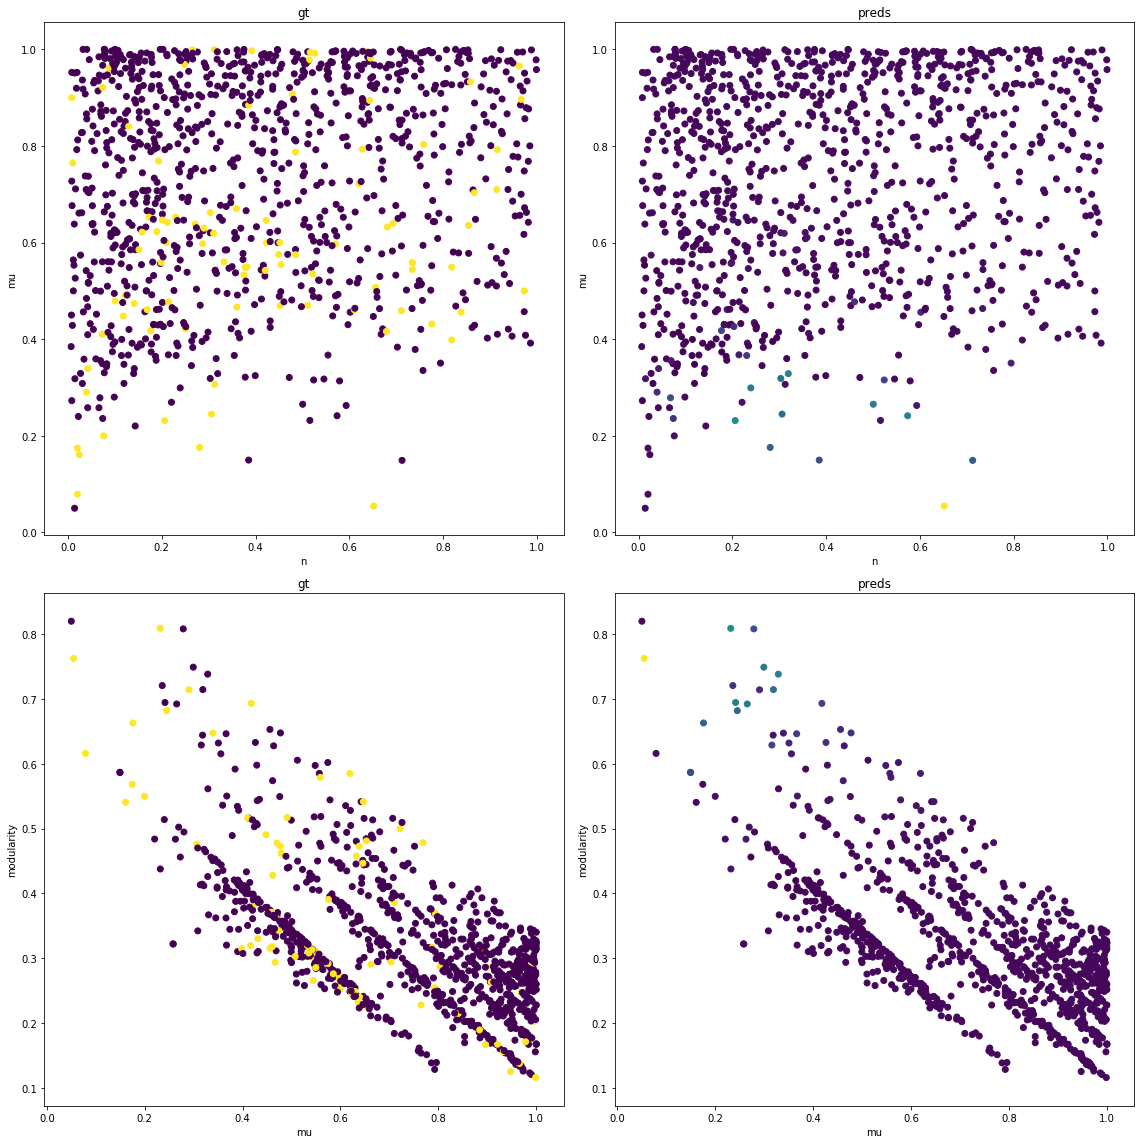

In [97]:
rfe.draw3d(tx, ty_bool, weights)

# RSP

In [92]:
measure_idx = 12
# ari_measure, ari_other = ty[:, measure_idx], np.max(np.concatenate((ty[:, :measure_idx], ty[:, measure_idx+1:]), axis=1), axis=1)
ari_measure, ari_other = tywo11[:, measure_idx], np.max(np.concatenate((tywo11[:, :measure_idx], tywo11[:, measure_idx+1:]), axis=1), axis=1)
win_weights = 1 / np.sum(ty == np.max(ty, axis=1, keepdims=True), axis=1)**3
lose_weights = np.abs(ari_measure - ari_other) * 5
weights = [ww if ari_m >= ari_o else lw for ari_m, ari_o, ww, lw in zip(ari_measure, ari_other, win_weights, lose_weights)]

ty_bool = ari_measure >= ari_other
print(f'{kernels_order[measure_idx]}', np.sum(ty_bool))

rfe = RFE(SVC(probability=True), feature_names, max_features=7)
rfe.fit(tx, ty_bool, weights)

RSP 100
all features, f1=0.057
1 features, f1=0.000, set=None
2 features, f1=0.075, set=('average_degree/n', 'modularity')
3 features, f1=0.237, set=('n', 'tau1', 'modularity')
4 features, f1=0.186, set=('n', 'mu', 'average_degree/n', 'modularity')
5 features, f1=0.174, set=('n', 'tau1', 'mu', 'average_degree/n', 'modularity')
6 features, f1=0.202, set=('n', 'tau1', 'tau2', 'mu', 'average_degree/n', 'modularity')
7 features, f1=0.109, set=('n', 'tau1', 'tau2', 'mu', 'average_degree/n', 'maxari', 'modularity')


('n', 'tau1', 'modularity')
[ True  True False False False False  True]
[0, 1, 6]
f1: 0.175


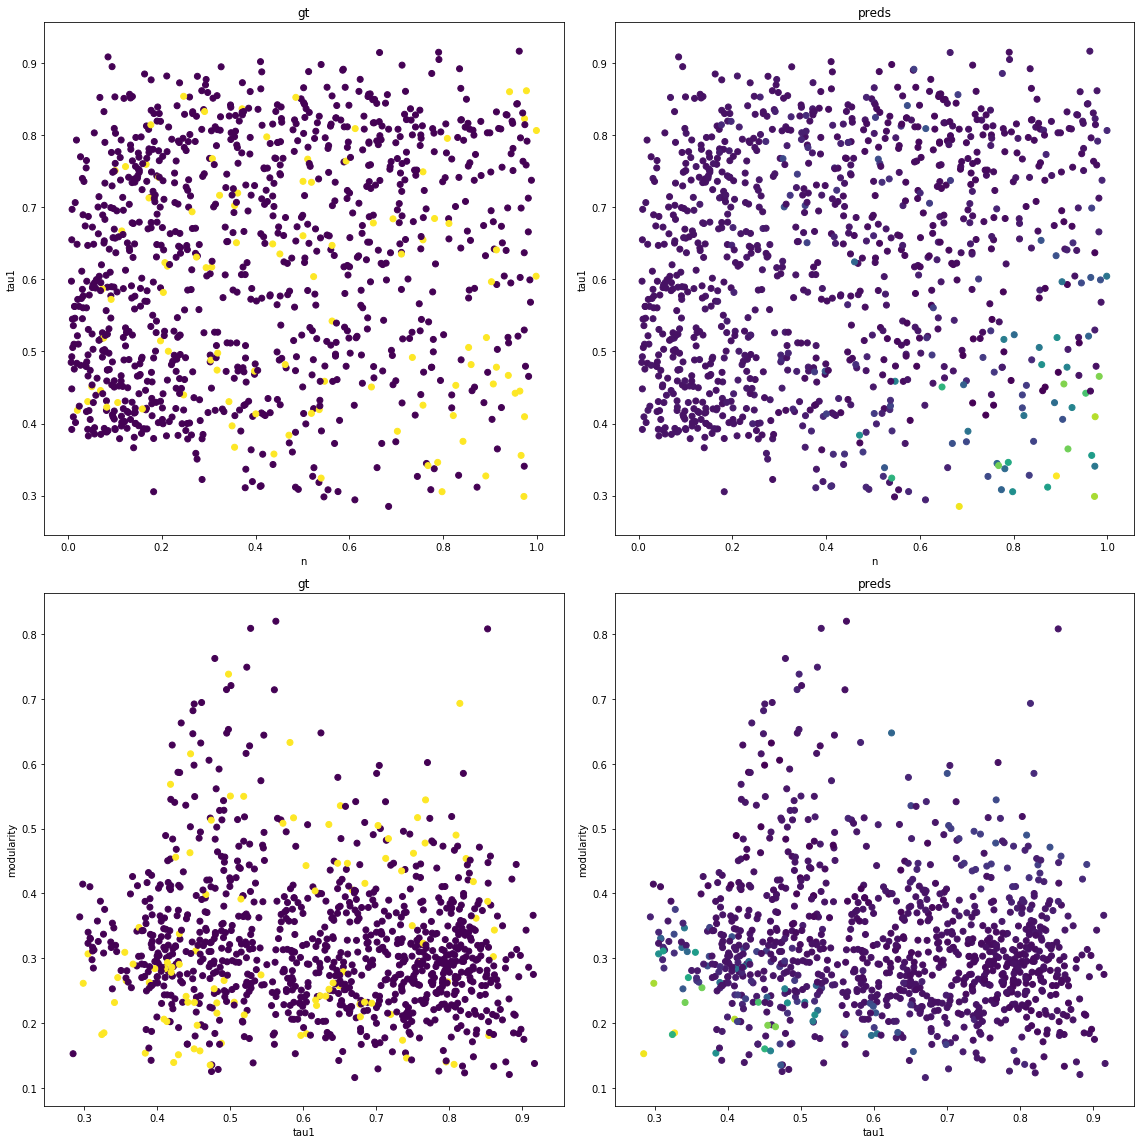

In [93]:
rfe.draw3d(tx, ty_bool, weights)

-----

In [52]:
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(tx, np.argmax(ty, axis=1))

KeyboardInterrupt: 

In [37]:
GaussianMixture().fit(X)

GaussianMixture()

In [38]:
svc.gamma

NameError: name 'svc' is not defined

In [ ]:
gmm_all =  GaussianMixture(n_components=1)
gmm_all.fit(tx)
means_all = gmm_all.means_[0]
cov_diag_all = gmm_all.covariances_[0].diagonal() 

for mode in range(2):
    fig, ax = plt.subplots(4, 3, figsize=(12, 7), sharex=True, sharey=False)

    for idx, (measure_idx, measure_name) in enumerate([
            (11, 'SCCT'),
            (8, 'NHeat'),
            (4, 'Comm'),
            (5, 'logComm'),
            (12, 'RSP'),
            (10, 'SCT'),
        ]):
        gmm = GaussianMixture(n_components=1)
        gmm.fit(tx[ty[:, measure_idx] == np.max(ty, axis=1)])
        
        if mode == 0:
            means_c0 = gmm.means_[0]
            cov_diag_c0 = gmm.covariances_[0].diagonal()
        else:
            means_c0 = gmm.means_[0] - gmm_all.means_[0]
            cov_diag_c0 = gmm.covariances_[0].diagonal() / gmm_all.covariances_[0].diagonal()

        image_means = np.zeros((3, len(feature_names)))
        image_cov_diag = np.zeros((3, len(feature_names)))
        for feature_idx, feature_name in enumerate(feature_names):
            image_means[0] = means_c0 + cov_diag_c0
            image_means[1] = means_c0
            image_means[2] = means_c0 - cov_diag_c0

        axi = ax[2 * (idx // 3)][idx % 3] 
        axi.imshow(image_means, vmin=-1 if mode else 0, vmax=1, cmap=plt.get_cmap('coolwarm'))
        axi.set_xticks(range(len(feature_names)))
        axi.set_xticklabels(feature_names, rotation=90)
        axi.set_yticks(range(3))
        axi.set_yticklabels(['mean + sigma', 'mean', 'mean - sigma'])
        axi.set_title(f'{measure_name} {"rel" if mode else "abs"}, {np.sum(ty[:, measure_idx] == np.max(ty, axis=1))} items')

        for feature_idx, feature_name in enumerate(feature_names):
            axi.text(feature_idx-0.35, 0.15, f'{image_means[0][feature_idx]:.2f}')
            axi.text(feature_idx-0.35, 1.15, f'{image_means[1][feature_idx]:.2f}')
            axi.text(feature_idx-0.35, 2.15, f'{image_means[2][feature_idx]:.2f}')

            
        image_means = np.abs(cov_diag_c0)[None]
            
        axi = ax[2 * (idx // 3) + 1][idx % 3]
        axi.imshow(image_means, vmin=0, vmax=1 if mode else 0.05)
        axi.set_xticks(range(len(feature_names)))
        axi.set_xticklabels(feature_names, rotation=90)
        axi.set_yticks(range(1))
        axi.set_yticklabels(['sigma'])

        for feature_idx, feature_name in enumerate(feature_names):
            axi.text(feature_idx-0.35, 0.15, f'{image_means[0][feature_idx]:.2f}')

    plt.tight_layout()
    plt.plot()